# Linearity bias

Demonstration of what happens when the generative model and generative process are not isomorphic.

==========================================================================

* **Notebook dependencies**:
    * ...

* **Content**: Jupyter notebook accompanying Chapter 2 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.utils import create_agent, create_environment

mpl.style.use("seaborn-deep")

All the previous examples have assumed an exact isomorphism between the generative model and generative process. That is, the generative process and model were identical except for some small differences in the noise. In many real-world scenarios we may need to design agents for generative processes who structure we do not know in advance. Later in the book we explore **structure learning** which shows how to learn the actual structure of the generative process with the data alone. In this example we show a simple example that demonstrates that an agent can perform well with a generative model that does not fully capture the generative process provided that some specific conditions are met. The generative model and process are as follows:

$$
    \mathscr{E} \triangleq  
    \begin{cases}
        y = g_{\mathscr{E}}(x^*; \theta^*) + \omega_y^*    & \text{Outcome generation} \\
        g_{\mathscr{E}}(x^*; \theta^*) = \beta_0^* + \beta_1^* \psi(x^*) & \text{Generating function} \\
        \psi(x^*) = {x^*}^2 & \text{Nonlinear transform of } x^* \\
        \omega_y^* \sim \mathcal{N}(0, \sigma^2=1) & \text{Observation noise} \\
        \theta^* := \left \{\beta_0^* = 3, \beta_1^* = 2 \right \} & \text{Observation parameters}
    \end{cases}
$$

$$
    \mathcal{M} \triangleq  
    \begin{cases}
        p_{\mu_y, \sigma^2_y}(y \mid x) = \mathcal{N}(y; g_{\mathcal{M}}, \sigma^2_y) & \text{Likelihood} \\
        p_{a_x, b_x}(x) = \mathcal{U}(x; a_x, b_x) & \text{State prior}\\
        g_{\mathcal{M}}(x; \theta) = \beta_0 + \beta_1 x & \text{Generating function} \\
        \theta := \left \{\beta_0 = 3, \beta_1 = 2 \right \}  & \text{Linear parameters} \\ 
        \phi := \left \{\sigma^2_y = 0.25, s^2_x = 0.25, m_x = 4 \right \} & \text{Other parameters}
    \end{cases}
$$

This means the model *believes* that the generating process is linear when it is in fact nonlinear. We say this because our choice of likelihood within the generative model is an assumption we are making about the generating process. In this case it happens to be false.

In [2]:
# Environment parameters
env_params = {
    "beta_0_star" : 1,    # Linear parameter intercept
    "beta_1_star" : 1,    # Linear parameter slope
    "y_star_std"  : 0.5  # Standard deviation of sensory data
}

# Initialize environment and agent
env = create_environment(name="static_nonlinear", params=env_params)

# Generate data for three different x_star values
num_x_star = 3                                         # Number of external states
x_range = np.linspace(start=0.01, stop=5, num=500)   # Range of x_star
x_star  = np.array([2, 2.5, 3.5])                      # 3 different external states
y       = np.zeros(num_x_star)                         # 3 corresponding observations

# Generate
for idx, x in enumerate(x_star):
    env.build(x)
    y[idx] = env.generate()

In [3]:
# Agent parameters
agent_params = {
    "beta_0" : 3,              # Linear parameter intercept
    "beta_1" : 2,              # Linear parameter slope
    "std_y"  : 0.5,  # Likelihood standard deviation
    "ax"     : 0.01,           # Prior uniform lower bound
    "bx"     : 5,            # Prior uniform upper bound
    "x_range": np.linspace(start=0.01, stop=5, num=500)
}

agent = create_agent(name="exact_linear_flat_prior", params=agent_params)

# Initialize list to store posteriors
posteriors = []

# Perform inference for each observations
for idx in range(num_x_star):
    agent.build(y[idx])
    agent.infer_state()
    posteriors.append(agent.posterior)

<Figure size 432x288 with 0 Axes>

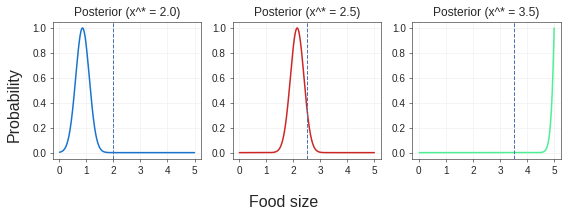

In [4]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1,3, facecolor=(1,1,1), figsize=(8,3))

# Main plot
axes[0].plot(x_range, posteriors[0], c="#1874cd")   # Posterior (x^*=2)
axes[1].plot(x_range, posteriors[1], c="#cd2626")   # Posterior (x^*=2.5)
axes[2].plot(x_range, posteriors[2], c="#4eee94")   # Posterior (x^*=3.5)

# Posterior mode and posterior axis
axes[0].axvline(x=x_star[0], linestyle="dashed", linewidth=1)
axes[1].axvline(x=x_star[1], linestyle="dashed", linewidth=1)
axes[2].axvline(x=x_star[2], linestyle="dashed", linewidth=1)

# Titles
axes[0].set_title(f"Posterior (x^* = {x_star[0]})")
axes[1].set_title(f"Posterior (x^* = {x_star[1]})")
axes[2].set_title(f"Posterior (x^* = {x_star[2]})")

# Axis global labels
fig.supxlabel("Food size", fontsize=16)
fig.supylabel("Probability", fontsize=16)

# Cosmetic changes and axes ranges
for ax in axes:
    ax.xaxis.set_ticks(np.arange(0, 6, 1))
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)
    
fig.tight_layout()